In [1]:
from featureextraction import generate_embeddings
import h5py
import matplotlib.pyplot as plt
from models import get_baseline_convolutional_encoder, build_siamese_net
import numpy as np
import os
import random
from scipy.signal import decimate
from sklearn.manifold import TSNE
import tensorflow as tf
import yaml

/Users/sutandia/venv/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sutandia/venv/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sutandia/venv/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sutandia/venv/capstone/lib/python3.7/site-packages/ten

In [9]:
# define train and test sets
train_set = ['Sham104', 'TBI103']
test_set = ['Sham102', 'TBI101']

# read EEG epochs - randomly sample num_samples from each class of each species
num_classes = 4
eeg_epoch_width_in_s = 32
num_samples = 100
epochs_path = 'data/epochs_{}c'.format(num_classes)
file_template = '{}_BL5_ew{}.h5'
train_sw_s_epochs = []
train_ss_s_epochs = []
train_tw_s_epochs = []
train_ts_s_epochs = []
for species in train_set:
    print('Working on', species)
    file_path = os.path.join(epochs_path, file_template.format(species, eeg_epoch_width_in_s))
    with h5py.File(file_path, 'r') as file:
        if 'Sham' in species:
            train_sw_s_epochs.extend(random.sample(list(file['eeg']['wake']), num_samples))
            train_ss_s_epochs.extend(random.sample(list(file['eeg']['sleep']), num_samples))
        elif 'TBI' in species:
            train_tw_s_epochs.extend(random.sample(list(file['eeg']['wake']), num_samples))
            train_ts_s_epochs.extend(random.sample(list(file['eeg']['sleep']), num_samples))
test_sw_s_epochs = []
test_ss_s_epochs = []
test_tw_s_epochs = []
test_ts_s_epochs = []
for species in test_set:
    print('Working on', species)
    file_path = os.path.join(epochs_path, file_template.format(species, eeg_epoch_width_in_s))
    with h5py.File(file_path, 'r') as file:
        if 'Sham' in species:
            test_sw_s_epochs.extend(random.sample(list(file['eeg']['wake']), num_samples))
            test_ss_s_epochs.extend(random.sample(list(file['eeg']['sleep']), num_samples))
        elif 'TBI' in species:
            test_tw_s_epochs.extend(random.sample(list(file['eeg']['wake']), num_samples))
            test_ts_s_epochs.extend(random.sample(list(file['eeg']['sleep']), num_samples))

Working on Sham104
Working on TBI103
Working on Sham102
Working on TBI101


In [10]:
# load a siamese model and generate embeddings for EEG epochs
models_path = 'models'
config_file = 'siam5_4c_ew32_25.yaml'
model_file = os.path.join(models_path, config_file)
train_sw_epochs = generate_embeddings(decimate(train_sw_s_epochs, 4), model_file)
train_ss_epochs = generate_embeddings(decimate(train_ss_s_epochs, 4), model_file)
train_tw_epochs = generate_embeddings(decimate(train_tw_s_epochs, 4), model_file)
train_ts_epochs = generate_embeddings(decimate(train_ts_s_epochs, 4), model_file)
test_sw_epochs = generate_embeddings(decimate(test_sw_s_epochs, 4), model_file)
test_ss_epochs = generate_embeddings(decimate(test_ss_s_epochs, 4), model_file)
test_tw_epochs = generate_embeddings(decimate(test_tw_s_epochs, 4), model_file)
test_ts_epochs = generate_embeddings(decimate(test_ts_s_epochs, 4), model_file)

In [6]:
# reduce dimensionality using t-SNE
tsne = TSNE(perplexity=30, early_exaggeration=12.0, learning_rate=600.0, method='exact', init='pca', verbose=1,
            n_iter=40000)
train_sw_epochs = tsne.fit_transform(train_sw_epochs)
train_ss_epochs = tsne.fit_transform(train_ss_epochs)
train_tw_epochs = tsne.fit_transform(train_tw_epochs)
train_ts_epochs = tsne.fit_transform(train_ts_epochs)
test_sw_epochs = tsne.fit_transform(test_sw_epochs)
test_ss_epochs = tsne.fit_transform(test_ss_epochs)
test_tw_epochs = tsne.fit_transform(test_tw_epochs)
test_ts_epochs = tsne.fit_transform(test_ts_epochs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 109.330192
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.930872
[t-SNE] KL divergence after 8100 iterations: 0.329613
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 9.821450
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.536299
[t-SNE] KL divergence after 1000 iterations: 0.723526
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 27.496543
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.093674
[t-SNE] KL divergence after 8600 iterations: 0.159698
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 9.853132
[t-SNE] KL divergence after 250 iterations with early exaggeration: 8

<Figure size 864x864 with 0 Axes>

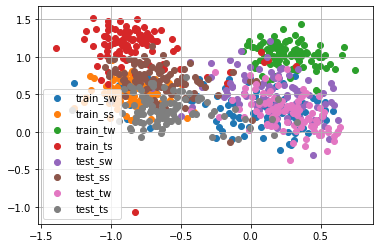

In [18]:
# plot t-SNE embeddings
plt.figure(figsize=(12.0, 12.0))
fig, ax = plt.subplots()
ax.scatter(train_sw_epochs[:, 0], train_sw_epochs[:, 1], label='train_sw')
ax.scatter(train_ss_epochs[:, 0], train_ss_epochs[:, 1],label='train_ss')
ax.scatter(train_tw_epochs[:, 0], train_tw_epochs[:, 1], label='train_tw')
ax.scatter(train_ts_epochs[:, 0], train_ts_epochs[:, 1], label='train_ts')
ax.scatter(test_sw_epochs[:, 0], test_sw_epochs[:, 1], label='test_sw')
ax.scatter(test_ss_epochs[:, 0], test_ss_epochs[:, 1], label='test_ss')
ax.scatter(test_tw_epochs[:, 0], test_tw_epochs[:, 1], label='test_tw')
ax.scatter(test_ts_epochs[:, 0], test_ts_epochs[:, 1], label='test_ts')
ax.legend()
ax.grid(True)

plt.show()